In [1]:
from vis import *
from landmarks import *
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Overlapped visualisation
landmarks = ["right bony anterior", 'right top orbit', "nasion"]
annotated = [3, 4, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24]
meshes = []
for i in annotated:
    path = get_ply_path(i)
    mesh = o3d.io.read_triangle_mesh(path)
    mesh_coloured = colour_mesh(mesh)
    matrix = get_rotation_matrix(i, landmarks)
    mesh_rotated = transform_mesh(mesh_coloured, matrix)
    mesh_rotated.compute_vertex_normals()
    if i == 13: mesh_rotated.vertices = o3d.utility.Vector3dVector(flip_left(mesh_rotated))
    mesh_rotated.vertices = o3d.utility.Vector3dVector(center_mesh_vertices(mesh_rotated))
    meshes.append(mesh_rotated)
o3d.visualization.draw_geometries(meshes, mesh_show_back_face=True)

In [2]:
# visualise_canal_planes(range(1, 25), "lateral")
visualise_subject_planes(2) 

In [2]:
annotated = [3, 4, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24]
# landmarks = ["right bony anterior", 'right top orbit', "nasion"]
# visualise_canal_planes(annotated, "anterior", landmarks)
# visualise_canal_planes(annotated, "lateral")
matrices = []
for i in annotated:
    matrices.append(get_rotation_matrix(i, landmarks))
print(np.mean(matrices, axis = 0))
print(np.std(matrices, axis = 0))

NameError: name 'landmarks' is not defined

In [3]:
def compute_normals(subjects, canal, landmarks=None):
    normals = []
    for subject in subjects:
        vals, vecs, vertices = get_canal_plane(subject, canal, landmarks)
        normals.append(vecs[:, 0])
    return np.array(normals)

def compute_normals_stats(subjects, canal, landmarks=None):
    normals = compute_normals(subjects, canal, landmarks)
    sample_cov = np.zeros((3, 3))
    mean_normal = np.mean(normals, axis = 0)
    for normal in normals:
        sample_cov += np.outer(normal-mean_normal, normal-mean_normal)
    return mean_normal, sample_cov / (len(subjects) - 1)

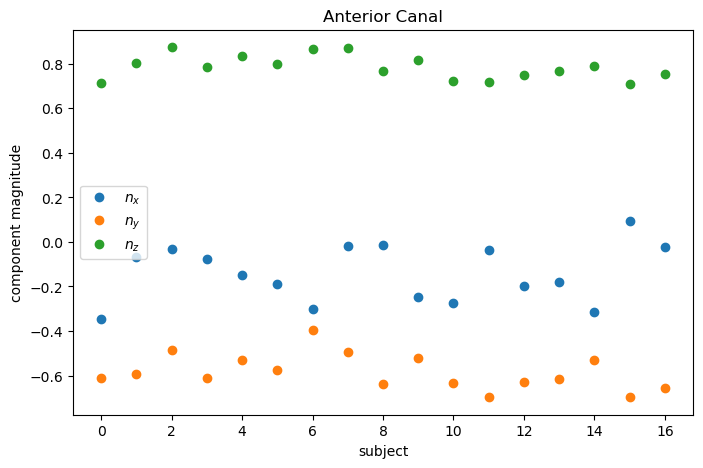

In [5]:
annotated = [3, 4, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24]
landmarks1 = ["nasion", "right bottom orbit",  'right top orbit']
landmarks2 = ["right soft anterior",  "right bottom orbit", 'right top orbit']
landmarks3 = ["right top orbit",  "nasion", 'right bottom orbit']
landmarks = landmarks1
canal = "posterior"
normals = compute_normals(annotated, canal, landmarks)
plt.plot(normals[:, 0], "o", label = "$n_x$")
plt.plot(normals[:, 1], "o", label = "$n_y$")
plt.plot(normals[:, 2], "o", label = "$n_z$")
plt.rcParams["figure.figsize"] = (8, 5)
plt.xlabel("subject")
plt.ylabel("component magnitude")
plt.title("Anterior Canal")
plt.legend()
plt.show()
# plt.savefig("../images/normal flipping/normal components " + canal + ".png")
# visualise_canal_planes(annotated, canal)

In [6]:
mu, sigma = compute_normals_stats(annotated[1:], "posterior", landmarks2)
print(mu, sigma, np.linalg.det(sigma), sep = "\n")

[-0.3170059  -0.14486972 -0.92518971]
[[ 0.00582512  0.00125145 -0.00197593]
 [ 0.00125145  0.01666641 -0.0039014 ]
 [-0.00197593 -0.0039014   0.00155543]]
1.4131422441503276e-08


[[ 2.07163289e-06 -3.01167270e-21]
 [-3.01167270e-21  3.44099101e-03]]
7.128470151139331e-09
[[ 0.00172153 -0.00171946]
 [-0.00171946  0.00172153]]
7.128470151140825e-09
[[ 0.00258126 -0.0014891 ]
 [-0.0014891   0.0008618 ]]
7.128470151137761e-09
[[0.00142295 0.00169334]
 [0.00169334 0.00202011]]
7.128470151138799e-09


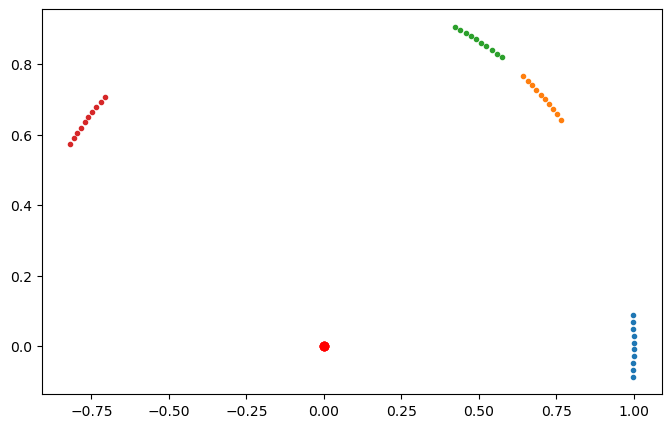

In [16]:
for direction in [0, 45, 60, 140]:
    angles = np.linspace(direction - 5, direction + 5, 10)/180*np.pi
    xs = np.array([np.cos(angles), np.sin(angles)]).T
    plt.plot(0, 0, "ro")
    plt.plot(xs[:, 0], xs[:, 1], ".")
    cov = np.zeros((2, 2))
    mean = np.mean(xs, axis=0)
    for x in xs:
        cov += np.outer(x-mean, x-mean)
    cov /= len(xs) - 1
    print(cov)
    print(np.linalg.det(cov))